In [1]:
import torch
from torch import nn

from pytorch.pytorch_tutorial import model_0

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [3]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
      """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


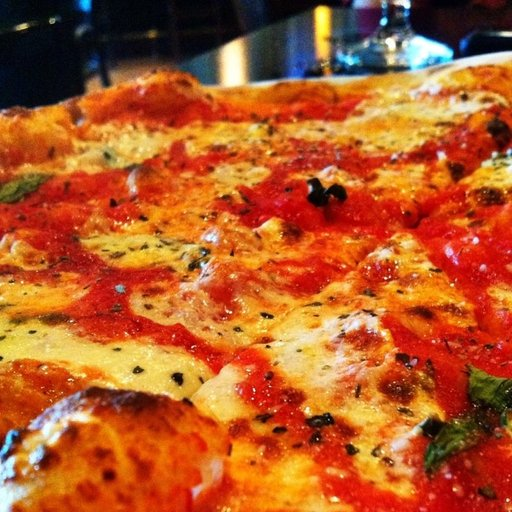

In [6]:
import random
from PIL import Image

# Set seed 
random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2 get random image path
random_image_path = random.choice(image_path_list)

# 3 Get image class from path name
image_class = random_image_path.parent.stem 

# 4 open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

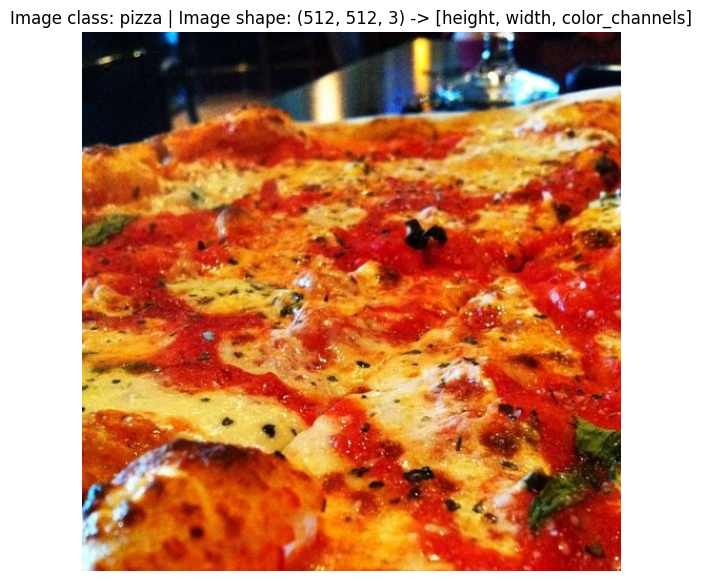

In [11]:
# Same can also be done with matplotlib but first we need to convert the image to Numpy array
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [17]:
# Write transform for image
data_transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.float32, scale=True),  # optional, most input are already uint8 at this point
    # Resize image to 224x224
    v2.RandomResizedCrop(size=(224, 224)),
    # Flip the images randomly on the horizontal axis
    v2.RandomHorizontalFlip(p=0.5),
    # Normalize the images
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6400006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5987122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0099466..2.6106405].


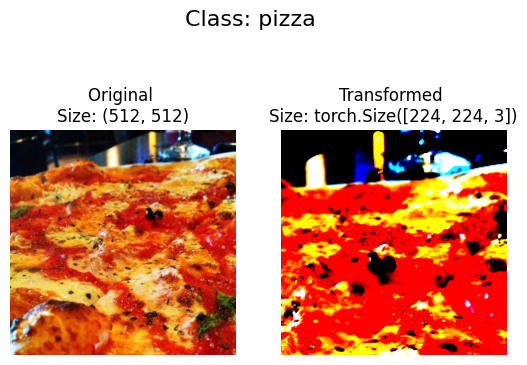

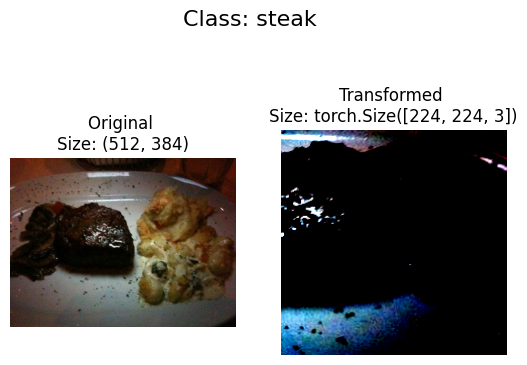

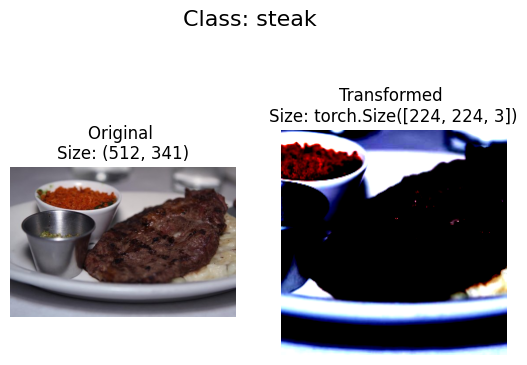

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform,
                        n=3)

In [19]:
# Use ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_Data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_Data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 Normalize(mean=[0.485, 0.456

In [20]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [21]:
# Get class names as a dictionary
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [22]:
# Check the lengths
len(train_data), len(test_Data)

(225, 75)

In [23]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
Image([[[-1.7399, -1.7404, -1.6815,  ..., -2.0396, -2.0657, -2.0794],
        [-1.7840, -1.6920, -1.7598,  ..., -2.0665, -2.0729, -2.0731],
        [-1.7647, -1.6920, -1.7598,  ..., -2.0665, -2.0920, -2.0838],
        ...,
        [-0.2380, -0.2968, -0.4005,  ...,  2.1188,  2.1605,  2.1297],
        [-0.2123, -0.3053, -0.3888,  ...,  2.1675,  2.1902,  2.1612],
        [-0.4141, -0.3949, -0.3998,  ...,  2.1666,  2.1584,  2.2316]],

       [[-1.7460, -1.7332, -1.6730,  ..., -2.0135, -1.9972, -1.9966],
        [-1.7644, -1.6704, -1.7397,  ..., -2.0007, -1.9903, -1.9899],
        [-1.7446, -1.6704, -1.7397,  ..., -2.0007, -2.0098, -2.0009],
        ...,
        [-1.0506, -1.1521, -1.2765,  ...,  2.4286,  2.4286,  2.3942],
        [-1.0554, -1.1988, -1.3039,  ...,  2.4286,  2.4286,  2.3942],
        [-1.2884, -1.3034, -1.3158,  ...,  2.4157,  2.3761,  2.4196]],

       [[-1.4847, -1.4457, -1.3858,  ..., -1.8044, -1.8005, -1.7925],
        [-1.5169, -1.4233, -1.4929,  ..., -1.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels


Text(0.5, 1.0, 'pizza')

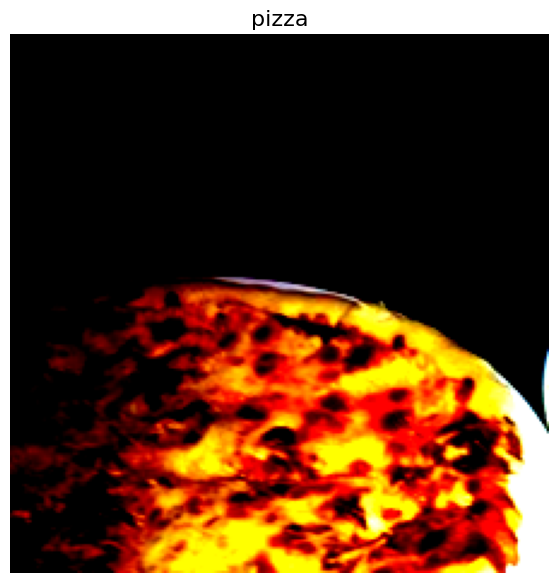

In [24]:
# Let's take a look at one image. We need to permute the image to suit matplotlib. Right now images dimension are as CHW but matplotlib expects HWC
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=16)

In [25]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=12)

test_dataloader = DataLoader(dataset=test_Data,
                             batch_size=32,
                             shuffle=False,
                             num_workers=12)

train_dataloader, test_dataloader



(<torch.utils.data.dataloader.DataLoader at 0x1450e4450>,
 <torch.utils.data.dataloader.DataLoader at 0x1450d3910>)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [27]:
# Let's create a model
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=3, bias=True)
  )
)

In [28]:
# Let's try the model on a single image
# 1. Get a batch of images and labels from the DataLoader
img_atch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_atch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}")

# 3 Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities: {torch.softmax(pred, dim=1)}\n")
print(f"Output prediction class: {torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label: {label_single}")

Single image shape: torch.Size([1, 3, 224, 224])
Output logits:
tensor([[ 0.0349,  0.0670, -0.0300]], device='mps:0')

Output prediction probabilities: tensor([[0.3367, 0.3477, 0.3156]], device='mps:0')

Output prediction class: tensor([1], device='mps:0')

Actual label: 1


In [29]:
# Use torchinfo to get an idea of the model
from torchinfo import summary
summary(model_0, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 10, 224, 224]         280
│    └─ReLU: 2-2                         [1, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 10, 224, 224]         910
│    └─ReLU: 2-4                         [1, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 10, 112, 112]         --
├─Sequential: 1-2                        [1, 10, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 10, 112, 112]         910
│    └─ReLU: 2-7                         [1, 10, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 10, 112, 112]         910
│    └─ReLU: 2-9                         [1, 10, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 10, 56, 56]           --
├─Sequentia

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [30]:
# Create a train step

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        #Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [31]:
# Let's create the test step

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy calues
    test_loss, test_acc = 0, 0


    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))

            # Calculate test loss and accuracy
            test_loss = test_loss / len(dataloader)
            test_acc = test_acc / len(dataloader)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
# Combine train and test functions

from tqdm import tqdm

# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    # Loop through training and test steps for a number of epochs